![Stryke Force Logo](https://avatars3.githubusercontent.com/u/20849460?v=3&s=200)

# Masking the Target
Let's experiment with several ways to isolate, or mask, the target in a sample image.

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['image.cmap'] = 'gray'

We use OpenCV to open the file and load into a `numpy` array. OpenCV loads the array with pixels in BGR order so we need to convert to RGB for displaying using `matplotlib`.

## The Original Image

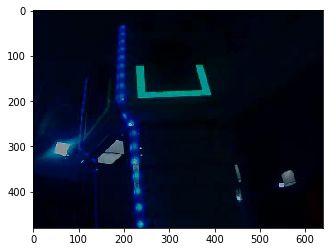

In [2]:
bgr_image = cv2.imread("images/15.jpg")
plt.imshow(cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB))
plt.show()

## Simple Grayscale Thresholding
A simple technique to obtaining a mask of our target is to use the [`cv2.threshold`](http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#threshold) function. This OpenCV [thresholding tutorial](http://docs.opencv.org/2.4/doc/tutorials/imgproc/threshold/threshold.html) has more information about how thresholding works.
The threshold function expects one channel of data so we'll convert our three-channel color BGR image to grayscale using [`cv2.cvtColor`](http://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#cvtcolor). We also apply [`cv2.GaussianBlur`](http://docs.opencv.org/2.4.13/modules/imgproc/doc/filtering.html?#gaussianblur) to reduce some of the high-frequency noise we are not interested in.

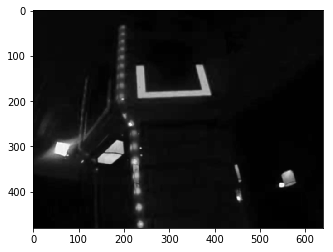

In [3]:
# convert to grayscale and apply blur
grayscale_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
grayscale_blurred_image = cv2.GaussianBlur(grayscale_image, (5, 5), 0)
plt.imshow(grayscale_blurred_image)
plt.show()

Applying simple thresholding requires us to select the threshold value, `T`, manually. All pixel values less than `T` in our grayscale image are set to 0 and all pixels greater than `T` are set to 255.

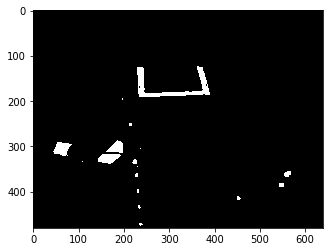

In [4]:
T = 99
(T, bw_thresholded_image) = cv2.threshold(grayscale_blurred_image, T, 255, cv2.THRESH_BINARY)
plt.imshow(bw_thresholded_image)
plt.show()

## BGR Color Range Selection
The simple grayscale threshold operation produced a decent result but we still have some large masked areas from the high-intensity pixels in some of the background lights in the original image. Let's see if we can do better by using the color information present in the original image.

We know that the target is reflecting a green light from the target so we'll select all pixels that fall within a color range for our target mask.

A repeatable method for getting a good BGR color range requires us to look at each channel. We sampled the target color using Photoshop and got the RGB values below. We'll create a standard deviation range around each of the average (mean) channel value of our sampled target color.

<img src="images/target_color_selection.png" height="200" width="200">
<table>
<tr><th>Blue</th><th>Green</th><th>Red</th></tr>
<tr>
<td><img src="images/blue_histogram.png" height="200" width="200"></td>
<td><img src="images/green_histogram.png" height="200" width="200"></td>
<td><img src="images/red_histogram.png" height="200" width="200"></td>
</tr>
<tr>
<td>Mean: 141<br/>Std Dev: 15</td>
<td>Mean: 145<br/>Std Dev: 15</td>
<td>Mean: 8<br/>Std Dev: 17</td>
</tr>
</table>

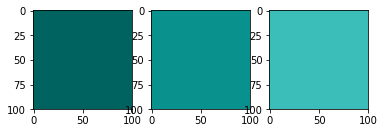

In [5]:
num_std_dev = 3
bgr_target_color = (141, 145, 8)
bgr_target_lower = (141 - num_std_dev*15, 144 - num_std_dev*15, 0)
bgr_target_upper = (141 + num_std_dev*15, 145 + num_std_dev*15, 8 + num_std_dev*17)

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(np.uint8([[bgr_target_lower]*100]*100), cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(np.uint8([[bgr_target_color]*100]*100), cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(np.uint8([[bgr_target_upper]*100]*100), cv2.COLOR_BGR2RGB))
plt.show()

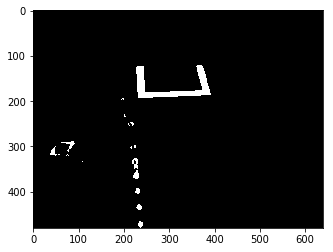

In [6]:
bgr_blurred_image = cv2.GaussianBlur(bgr_image, (5, 5), 0)
bgr_inrange_image = cv2.inRange(bgr_blurred_image, bgr_target_lower, bgr_target_upper)
plt.imshow(bgr_inrange_image)
plt.show()

## HSV Color Range Selection
The BGR color range selection looks to be better than simple grayscale thresholding, but how will it stand up to changes in camera range and light levels?

We'll now select pixels that fall within a range of two HSV colors. As before we looked at the image in Photoshop to select the best average color of the target in this particular image. A simple method of creating a HSV range is to take the sampled hue +/- 10° and always a large range for saturation and brightness. Since OpenCV uses an 8-bit integer in the range of 0-180 to represent the 360° of the color wheel we'll divide our sampled hue by 2.

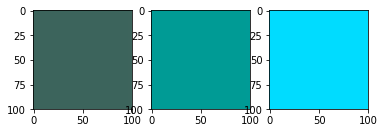

In [7]:
hsv_target_color = (178 // 2, 1.0 * 255, .61 * 255)
hsv_target_lower = (hsv_target_color[0] - 5, 100, 100)
hsv_target_upper = (hsv_target_color[0] + 5, 255, 255)

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(np.uint8([[hsv_target_lower]*100]*100), cv2.COLOR_HSV2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(np.uint8([[hsv_target_color]*100]*100), cv2.COLOR_HSV2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(np.uint8([[hsv_target_upper]*100]*100), cv2.COLOR_HSV2RGB))
plt.show()

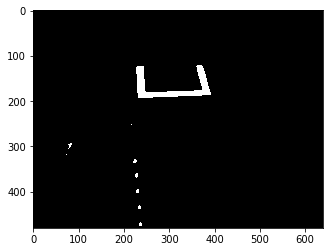

In [8]:
hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
hsv_blurred_image = cv2.GaussianBlur(hsv_image, (5, 5), 0)
hsv_inrange_image = cv2.inRange(hsv_blurred_image, hsv_target_lower, hsv_target_upper)
plt.imshow(hsv_inrange_image)
plt.show()

As we can see above, HSV masking does a better job of removing light sources in the background and on the tower, even with a broad selection range for value (brightness).